# E-commerce Customer Analytics Project

End-to-end analysis of 100,000+ orders from a Brazilian online store.

## 1. Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ρυθμίσεις εμφάνισης
plt.style.use("ggplot")
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_geolocation_dataset.csv to olist_geolocation_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv
Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv
Saving olist_sellers_dataset.csv to olist_sellers_dataset.csv
Saving product_category_name_translation.csv to product_category_name_translation.csv


In [ ]:
orders = pd.read_csv("olist_orders_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
product_category_translation = pd.read_csv("product_category_name_translation.csv")

In [ ]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
orders.info()
orders.describe(include='all')
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
customers.info()
customers.describe(include='all')
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

## 2. Data Cleaning & Preprocessing

In [ ]:
products.info()
products.describe(include='all')
products.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
sellers.info()
sellers.describe(include='all')
sellers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [ ]:
order_reviews.info()
order_reviews.describe(include='all')
order_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date'])

In [ ]:
order_payments.info()
order_payments.describe(include='all')
order_payments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
geolocation.info()
geolocation.describe(include='all')
geolocation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [ ]:
product_category_translation.info()
product_category_translation.describe(include='all')
product_category_translation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
orders.isnull().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


In [ ]:
customers.isnull().sum()

,0
customer_id,0
customer_unique_id,0
customer_zip_code_prefix,0
customer_city,0
customer_state,0


In [ ]:
order_items.isnull().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0


In [ ]:
products.isnull().sum()

,0
product_id,0
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2


In [ ]:
sellers.isnull().sum()

,0
seller_id,0
seller_zip_code_prefix,0
seller_city,0
seller_state,0


In [ ]:
order_reviews.isnull().sum()

,0
review_id,0
order_id,0
review_score,0
review_comment_title,87656
review_comment_message,58247
review_creation_date,0
review_answer_timestamp,0


In [ ]:
order_payments.isnull().sum()

,0
order_id,0
payment_sequential,0
payment_type,0
payment_installments,0
payment_value,0


In [ ]:
geolocation.isnull().sum()

,0
geolocation_zip_code_prefix,0
geolocation_lat,0
geolocation_lng,0
geolocation_city,0
geolocation_state,0


In [ ]:
product_category_translation.isnull().sum()

,0
product_category_name,0
product_category_name_english,0


In [ ]:
orders['customer_id'].nunique()

99441

## 3. Customer Segmentation (RFM Analysis)

In [ ]:
customer_order_counts = orders.groupby('customer_id')['order_id'].count().reset_index()
customer_order_counts.columns = ['customer_id', 'num_orders']

In [ ]:
customer_order_counts['num_orders'].describe()

,num_orders
count,99441.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


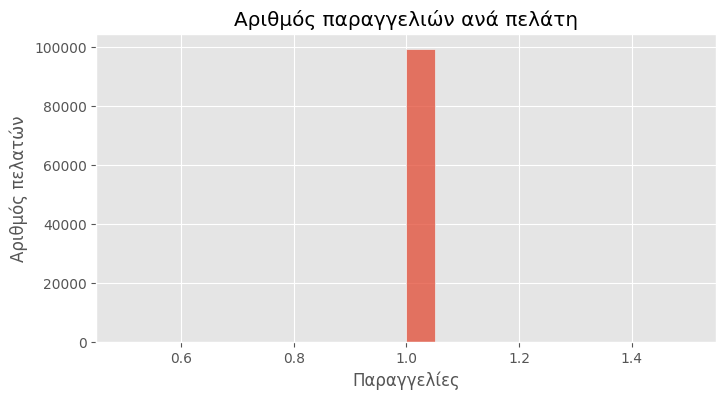

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(customer_order_counts['num_orders'], bins=20, kde=False)
plt.title("Αριθμός παραγγελιών ανά πελάτη")
plt.xlabel("Παραγγελίες")
plt.ylabel("Αριθμός πελατών")
plt.show()

In [ ]:
top_customers = customer_order_counts.sort_values(by='num_orders', ascending=False).head(10)
top_customers

,customer_id,num_orders
99440,ffffe8b65bbe3087b653a978c870db99,1
99424,fff5169e583fd07fac9fec88962f189d,1
99423,fff4fdd0de70a51d4e0f57a4c1c6bfae,1
99422,fff4f0c85a4d710abe06599e1ed08a42,1
99421,fff415b4c72e09483a25c15108c65d31,1
99420,fff3a5c6d542d52b05f7e4518adf996e,1
99419,fff39f01a81d96b066b1893ad395a98b,1
99418,fff25ab9d3c9ba6ad8119576f285a3d9,1
99417,fff212062d600f2e1d53f3c5d4a25138,1
99416,fff200ad56bd3e1caa576cce9d282672,1


In [ ]:
repeat_customers = customer_order_counts[customer_order_counts['num_orders'] > 1]
repeat_customers.shape[0]

0

In [ ]:
total_customers = customer_order_counts.shape[0]
repeat_customer_rate = repeat_customers.shape[0] / total_customers
print(f"Repeat Customer Rate: {repeat_customer_rate:.2%}")

Repeat Customer Rate: 0.00%


In [ ]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
orders = orders.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

In [ ]:
customer_order_counts = orders.groupby('customer_unique_id')['order_id'].count().reset_index()
customer_order_counts.columns = ['customer_unique_id', 'num_orders']

In [ ]:
orders['customer_unique_id'].nunique()

96096

In [ ]:
customer_order_counts['num_orders'].describe()

,num_orders
count,96096.000000
mean,1.034809
std,0.214384
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,17.000000


In [ ]:
repeat_customers = customer_order_counts[customer_order_counts['num_orders'] > 1]
repeat_customers.shape[0]

2997

In [ ]:
total_customers = customer_order_counts.shape[0]
repeat_customer_rate = repeat_customers.shape[0] / total_customers
print(f"Repeat Customer Rate: {repeat_customer_rate:.2%}")

Repeat Customer Rate: 3.12%


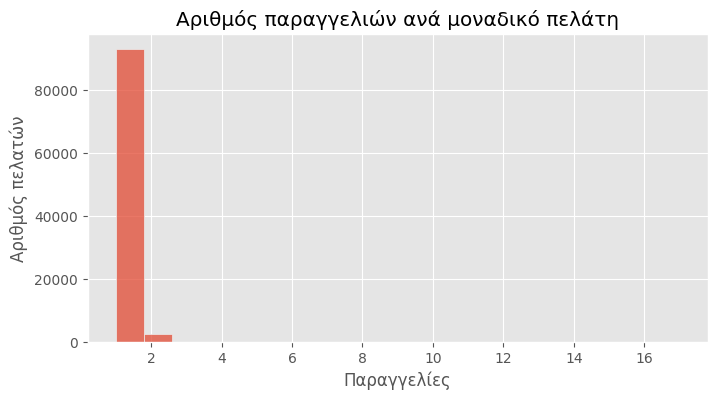

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(customer_order_counts['num_orders'], bins=20, kde=False)
plt.title("Αριθμός παραγγελιών ανά μοναδικό πελάτη")
plt.xlabel("Παραγγελίες")
plt.ylabel("Αριθμός πελατών")
plt.show()

In [ ]:
completed_orders = orders[orders['order_status'] == 'delivered']

In [ ]:
snapshot_date = completed_orders['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

## 4. Delivery Performance Analysis

In [ ]:
rfm = completed_orders.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count'
}).reset_index()

rfm.columns = ['customer_unique_id', 'recency', 'frequency']

In [ ]:
completed_orders = completed_orders.merge(order_payments, on='order_id', how='left')

In [ ]:
monetary = completed_orders.groupby('customer_unique_id')['payment_value'].sum().reset_index()
monetary.columns = ['customer_unique_id', 'monetary']

In [ ]:
rfm = rfm.merge(monetary, on='customer_unique_id', how='left')

In [ ]:
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])

In [ ]:
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

In [ ]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214


In [ ]:
rfm[['recency', 'frequency', 'monetary']].describe()

,recency,frequency,monetary
count,93358.000000,93358.000000,93358.000000
mean,237.941773,1.033420,165.197003
std,152.591453,0.209097,226.314012
min,1.000000,1.000000,0.000000
25%,114.000000,1.000000,63.052500
50%,219.000000,1.000000,107.780000
75%,346.000000,1.000000,182.557500
max,714.000000,15.000000,13664.080000


In [ ]:
rfm['rfm_score'].value_counts().sort_index()

,count
rfm_score,
111,799
112,806
113,779
114,709
115,734
...,...
551,644
552,667
553,695


In [ ]:
def rfm_segment(row):
    if row['r_score'] >= 4 and row['f_score'] >= 4 and row['m_score'] >= 4:
        return 'Champions'
    elif row['r_score'] >= 3 and row['f_score'] >= 3:
        return 'Loyal Customers'
    elif row['r_score'] <= 2 and row['f_score'] >= 3:
        return 'At Risk'
    elif row['r_score'] == 5 and row['f_score'] == 1:
        return 'New Customers'
    elif row['r_score'] <= 2 and row['f_score'] == 1:
        return 'Hibernating'
    else:
        return 'Others'

In [ ]:
rfm['segment'] = rfm.apply(rfm_segment, axis=1)

In [ ]:
rfm['segment'].value_counts()

,count
segment,
Loyal Customers,27292
Others,26140
At Risk,22230
Hibernating,7483
Champions,6493
New Customers,3720


In [ ]:
rfm[['customer_unique_id', 'rfm_score', 'segment']].head()

,customer_unique_id,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,414,Others
1,0000b849f77a49e4a4ce2b2a4ca5be3f,411,Others
2,0000f46a3911fa3c0805444483337064,112,Hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,211,Hibernating
4,0004aac84e0df4da2b147fca70cf8255,214,Hibernating


In [ ]:
rfm[['customer_unique_id', 'rfm_score', 'segment']].sample(5, random_state=42)

,customer_unique_id,rfm_score,segment
21568,3af0b2f7654f613ff1527b997a2ac57e,321,Others
52028,8ef940c8c63e85e9e2fd65f7e8b6581c,532,Loyal Customers
74245,cb5c545d96f39390b7f372aaa88c4a7e,253,At Risk
45830,7d6b089029085b9d544174ab78412378,235,At Risk
33285,5af79d89508d36628b0796f94afa3fa9,522,Others


<ipython-input-55-6eaa64e5e1a0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='segment', order=rfm['segment'].value_counts().index, palette='viridis')


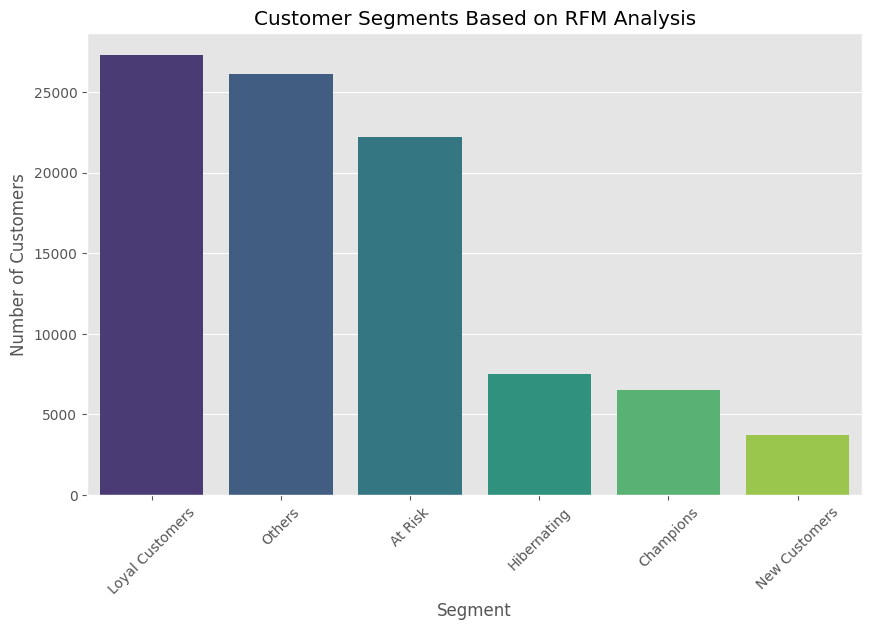

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='segment', order=rfm['segment'].value_counts().index, palette='viridis')
plt.title('Customer Segments Based on RFM Analysis')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

In [ ]:
rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(2)

recency frequency monetary       
                   mean      mean     mean  count
segment                                          
At Risk          394.66      1.05   166.97  22230
Champions         91.11      1.18   312.13   6493
Hibernating      396.72      1.00   162.84   7483
Loyal Customers  144.23      1.03   134.02  27292
New Customers     45.95      1.00   160.77   3720
Others           220.85      1.00   161.05  26140

In [ ]:
delivered_orders = orders[orders['order_status'] == 'delivered'].copy()

In [ ]:
delivered_orders['delivery_days'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']).dt.days

In [ ]:
delivered_orders['shipping_days'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_approved_at']).dt.days

In [ ]:
delivered_orders['estimated_days'] = (delivered_orders['order_estimated_delivery_date'] - delivered_orders['order_purchase_timestamp']).dt.days
delivered_orders['delay'] = delivered_orders['delivery_days'] - delivered_orders['estimated_days']

In [ ]:
delivered_orders[['delivery_days', 'shipping_days', 'estimated_days', 'delay']].describe()

,delivery_days,shipping_days,estimated_days,delay
count,96470.000000,96456.000000,96478.000000,96470.000000
mean,12.093604,11.642459,23.372759,-11.279144
std,9.551380,9.520355,8.758137,10.192137
min,0.000000,-7.000000,2.000000,-146.000000
25%,6.000000,6.000000,18.000000,-16.000000
50%,10.000000,9.000000,23.000000,-12.000000
75%,15.000000,15.000000,28.000000,-7.000000
max,209.000000,208.000000,155.000000,189.000000


## 5. Payment Analysis

In [ ]:
delivered_orders.sort_values('delay', ascending=False)[['order_id', 'delivery_days', 'estimated_days', 'delay']].head(10)

,order_id,delivery_days,estimated_days,delay
55619,1b3190b2dfa9d789e1f14c05b647a14a,208.0,19,189.0
19590,ca07593549f1816d26a572e06dc1eab6,209.0,28,181.0
11399,47b40429ed8cce3aee9199792275433f,191.0,15,176.0
81401,2fe324febf907e3ea3f2aa9650869fa5,189.0,22,167.0
89130,285ab9426d6982034523a855f55a885e,194.0,28,166.0
61610,440d0d17af552815d15a9e41abe49359,195.0,30,165.0
40847,d24e8541128cea179a11a65176e0a96f,175.0,13,162.0
38509,0f4519c5f1c541ddec9f21b3bddd533a,194.0,32,162.0
68769,c27815f7e3dd0b926b58552628481575,187.0,25,162.0
54480,2d7561026d542c8dbd8f0daeadf67a43,188.0,28,160.0


In [ ]:
delivered_orders[['delivery_days', 'shipping_days', 'estimated_days', 'delay']].describe()

,delivery_days,shipping_days,estimated_days,delay
count,96470.000000,96456.000000,96478.000000,96470.000000
mean,12.093604,11.642459,23.372759,-11.279144
std,9.551380,9.520355,8.758137,10.192137
min,0.000000,-7.000000,2.000000,-146.000000
25%,6.000000,6.000000,18.000000,-16.000000
50%,10.000000,9.000000,23.000000,-12.000000
75%,15.000000,15.000000,28.000000,-7.000000
max,209.000000,208.000000,155.000000,189.000000


In [ ]:
delivered_orders.sort_values('delay', ascending=False)[['order_id', 'delivery_days', 'estimated_days', 'delay']].head(10)

,order_id,delivery_days,estimated_days,delay
55619,1b3190b2dfa9d789e1f14c05b647a14a,208.0,19,189.0
19590,ca07593549f1816d26a572e06dc1eab6,209.0,28,181.0
11399,47b40429ed8cce3aee9199792275433f,191.0,15,176.0
81401,2fe324febf907e3ea3f2aa9650869fa5,189.0,22,167.0
89130,285ab9426d6982034523a855f55a885e,194.0,28,166.0
61610,440d0d17af552815d15a9e41abe49359,195.0,30,165.0
40847,d24e8541128cea179a11a65176e0a96f,175.0,13,162.0
38509,0f4519c5f1c541ddec9f21b3bddd533a,194.0,32,162.0
68769,c27815f7e3dd0b926b58552628481575,187.0,25,162.0
54480,2d7561026d542c8dbd8f0daeadf67a43,188.0,28,160.0


In [ ]:
filtered_deliveries = delivered_orders[
    (delivered_orders['delay'] >= -30) &
    (delivered_orders['delay'] <= 60)
]

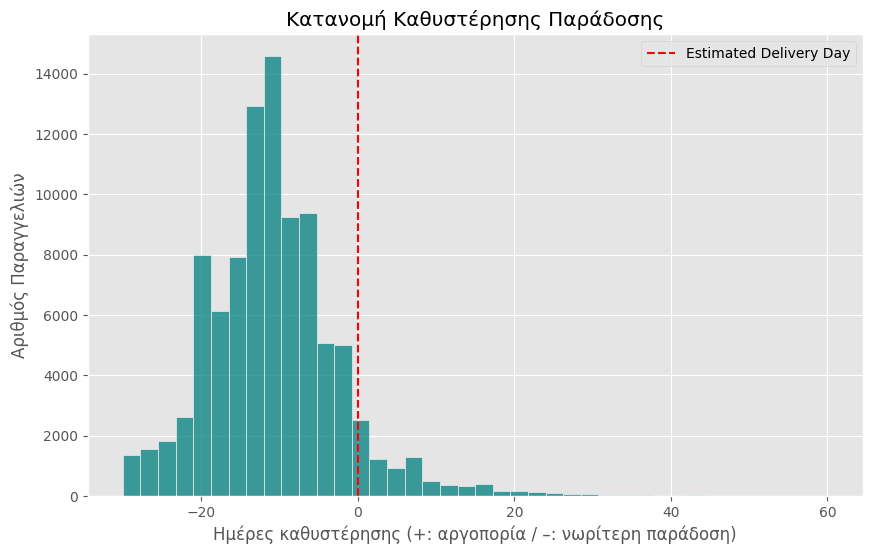

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(filtered_deliveries['delay'], bins=40, kde=False, color='teal')
plt.title('Κατανομή Καθυστέρησης Παράδοσης')
plt.xlabel('Ημέρες καθυστέρησης (+: αργοπορία / –: νωρίτερη παράδοση)')
plt.ylabel('Αριθμός Παραγγελιών')
plt.axvline(0, color='red', linestyle='--', label='Estimated Delivery Day')
plt.legend()
plt.show()

In [ ]:
merged = delivered_orders.merge(order_items, on='order_id', how='left')

In [ ]:
merged = merged.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

In [ ]:
category_delay = merged[
    (merged['delay'] >= -30) & (merged['delay'] <= 60)
]

In [ ]:
avg_delay_per_category = category_delay.groupby('product_category_name')['delay'].mean().sort_values(ascending=False).reset_index()

<ipython-input-71-b43908d241b9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_delay_per_category.head(15), x='delay', y='product_category_name', palette='coolwarm')


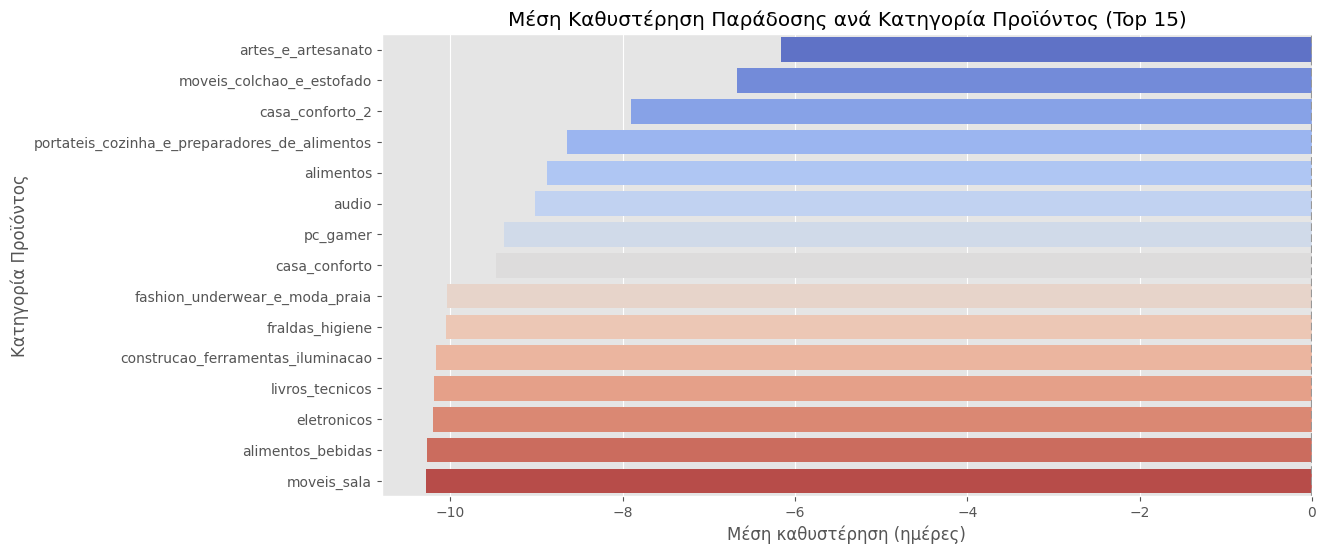

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=avg_delay_per_category.head(15), x='delay', y='product_category_name', palette='coolwarm')
plt.title('Μέση Καθυστέρηση Παράδοσης ανά Κατηγορία Προϊόντος (Top 15)')
plt.xlabel('Μέση καθυστέρηση (ημέρες)')
plt.ylabel('Κατηγορία Προϊόντος')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

In [ ]:
avg_delay_per_category.head(15)

,product_category_name,delay
0,artes_e_artesanato,-6.166667
1,moveis_colchao_e_estofado,-6.675676
2,casa_conforto_2,-7.900000
3,portateis_cozinha_e_preparadores_de_alimentos,-8.642857
4,alimentos,-8.881988
5,audio,-9.022535
6,pc_gamer,-9.375000
7,casa_conforto,-9.471831
8,fashion_underwear_e_moda_praia,-10.039683
9,fraldas_higiene,-10.055556


In [ ]:
geo_merged = delivered_orders.merge(customers[['customer_id', 'customer_state']], on='customer_id', how='left')

NameError: name 'delivered_orders' is not defined

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv


## 6. Product-Level Sales & Revenue

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
pd.set_option('display.max_columns', None)

# Read datasets
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=[
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date'
])
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")

In [ ]:
geo_merged = delivered_orders.merge(customers[['customer_id', 'customer_state']], on='customer_id', how='left')

In [ ]:
geo_filtered = geo_merged[
    (geo_merged['delay'] >= -30) & (geo_merged['delay'] <= 60)
]

In [ ]:
avg_delay_per_state = geo_filtered.groupby('customer_state')['delay'].mean().sort_values(ascending=False).reset_index()

<ipython-input-8-6044885aa5c7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_delay_per_state, x='delay', y='customer_state', palette='coolwarm')


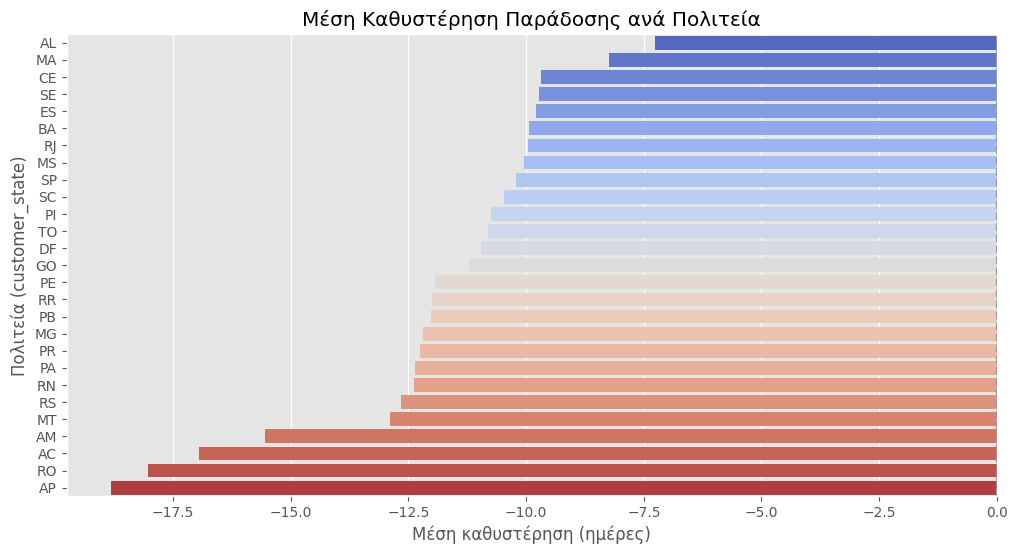

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=avg_delay_per_state, x='delay', y='customer_state', palette='coolwarm')
plt.title('Μέση Καθυστέρηση Παράδοσης ανά Πολιτεία')
plt.xlabel('Μέση καθυστέρηση (ημέρες)')
plt.ylabel('Πολιτεία (customer_state)')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

In [ ]:
avg_delay_per_state.head(10)

,customer_state,delay
0,AL,-7.256477
1,MA,-8.249284
2,CE,-9.680097
3,SE,-9.736842
4,ES,-9.800306
5,BA,-9.948613
6,RJ,-9.967167
7,MS,-10.047757
8,SP,-10.219099
9,SC,-10.470538


<ipython-input-6-f83a76d131f6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=payments_merged, y='payment_type', order=payments_merged['payment_type'].value_counts().index, palette='Set2')


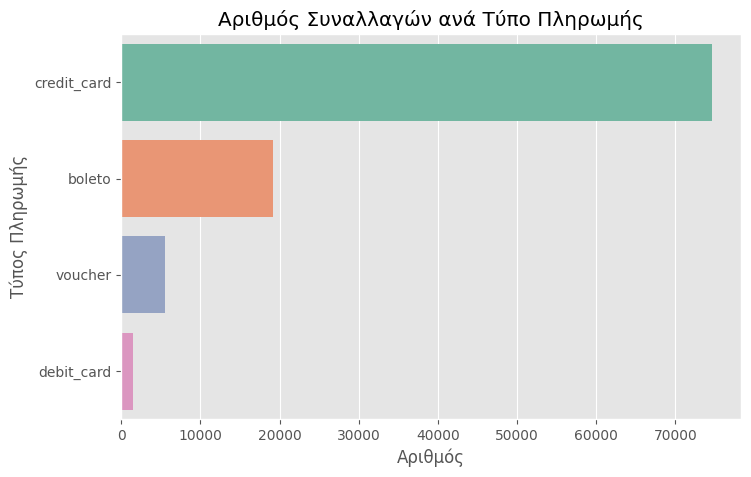

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=payments_merged, y='payment_type', order=payments_merged['payment_type'].value_counts().index, palette='Set2')
plt.title('Αριθμός Συναλλαγών ανά Τύπο Πληρωμής')
plt.xlabel('Αριθμός')
plt.ylabel('Τύπος Πληρωμής')
plt.show()

## 7. Review Score & Delivery Time

<ipython-input-7-c2bba09f205f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_avg_value.values, y=payment_avg_value.index, palette='Set1')


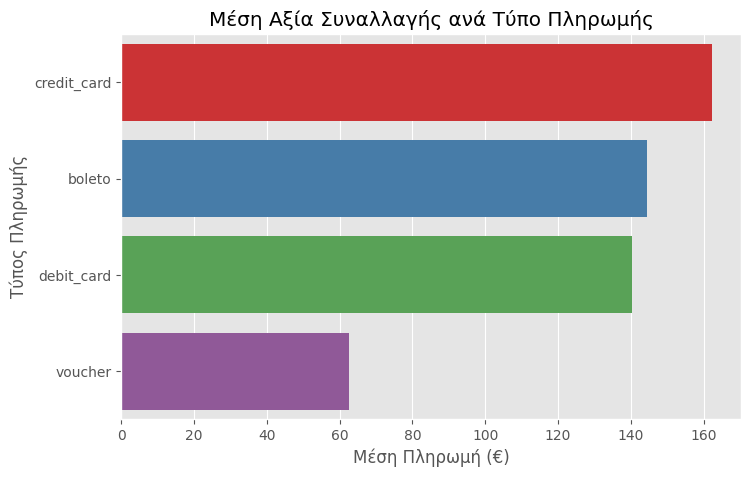

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=payment_avg_value.values, y=payment_avg_value.index, palette='Set1')
plt.title('Μέση Αξία Συναλλαγής ανά Τύπο Πληρωμής')
plt.xlabel('Μέση Πληρωμή (€)')
plt.ylabel('Τύπος Πληρωμής')
plt.show()

In [ ]:
installments_per_type

,payment_installments,payment_value,transaction_count
payment_type,,,
credit_card,3.5,162.24,74586
boleto,1.0,144.33,19191
voucher,1.0,62.45,5493
debit_card,1.0,140.26,1486


In [ ]:
product_sales = order_items.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

In [ ]:
product_metrics = product_sales.groupby('product_id').agg({
    'order_item_id': 'count',         # αριθμός πωλήσεων (τεμαχίων)
    'price': 'sum',                   # συνολικό έσοδο
    'freight_value': 'sum',           # συνολικά μεταφορικά
    'product_category_name': 'first'  # παίρνουμε την κατηγορία
}).rename(columns={
    'order_item_id': 'units_sold',
    'price': 'total_revenue',
    'freight_value': 'total_freight'
}).reset_index()

In [ ]:
top_selling = product_metrics.sort_values(by='units_sold', ascending=False).head(10)
top_selling

,product_id,units_sold,total_revenue,total_freight,product_category_name
22112,aca2eb7d00ea1a7b8ebd4e68314663af,527,37608.90,7211.86,moveis_decoracao
19742,99a4788cb24856965c36a24e339b6058,488,43025.56,8046.04,cama_mesa_banho
8613,422879e10f46682990de24d770e7f83d,484,26577.22,7624.04,ferramentas_jardim
7364,389d119b48cf3043d311335e499d9c6b,392,21440.59,7242.09,ferramentas_jardim
7079,368c6c730842d78016ad823897a372db,388,21056.80,6927.60,ferramentas_jardim
10840,53759a2ecddad2bb87a079a1f1519f73,373,20387.20,6881.03,ferramentas_jardim
27039,d1c427060a0f73f6b889a5c7c61f2ac4,343,47214.51,13761.52,informatica_acessorios
10867,53b36df67ebb7c41585e8d54d6772e08,323,37683.42,2274.51,relogios_presentes
2794,154e7e31ebfa092203795c972e5804a6,281,6325.19,3737.92,beleza_saude
8051,3dd2a17168ec895c781a9191c1e95ad7,274,41082.60,7129.62,informatica_acessorios


In [ ]:
top_revenue = product_metrics.sort_values(by='total_revenue', ascending=False).head(10)
top_revenue

,product_id,units_sold,total_revenue,total_freight,product_category_name
24086,bb50f2e236e5eea0100680137654686c,195,63885.00,3721.10,beleza_saude
14068,6cdd53843498f92890544667809f1595,156,54730.20,4363.79,beleza_saude
27613,d6160fb7873f184099d9bc95e30376af,35,48899.34,1426.84,pcs
27039,d1c427060a0f73f6b889a5c7c61f2ac4,343,47214.51,13761.52,informatica_acessorios
19742,99a4788cb24856965c36a24e339b6058,488,43025.56,8046.04,cama_mesa_banho
8051,3dd2a17168ec895c781a9191c1e95ad7,274,41082.60,7129.62,informatica_acessorios
4996,25c38557cf793876c5abdd5931f922db,38,38907.32,1404.63,bebes
12351,5f504b3a1c75b73d6151be81eb05bdc9,63,37733.90,3991.91,cool_stuff
10867,53b36df67ebb7c41585e8d54d6772e08,323,37683.42,2274.51,relogios_presentes
22112,aca2eb7d00ea1a7b8ebd4e68314663af,527,37608.90,7211.86,moveis_decoracao


In [ ]:
category_metrics = product_metrics.groupby('product_category_name').agg({
    'units_sold': 'sum',
    'total_revenue': 'sum',
    'total_freight': 'sum'
}).sort_values('units_sold', ascending=False).reset_index()

In [ ]:
category_metrics.head(10)

,product_category_name,units_sold,total_revenue,total_freight
0,cama_mesa_banho,11115,1036988.68,204693.04
1,beleza_saude,9670,1258681.34,182566.73
2,esporte_lazer,8641,988048.97,168607.51
3,moveis_decoracao,8334,729762.49,172749.30
4,informatica_acessorios,7827,911954.32,147318.08
5,utilidades_domesticas,6964,632248.66,146149.11
6,relogios_presentes,5991,1205005.68,100535.93
7,telefonia,4545,323667.53,71215.79
8,ferramentas_jardim,4347,485256.46,98962.75
9,automotivo,4235,592720.11,92664.21


<ipython-input-15-5f55aaa4a540>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


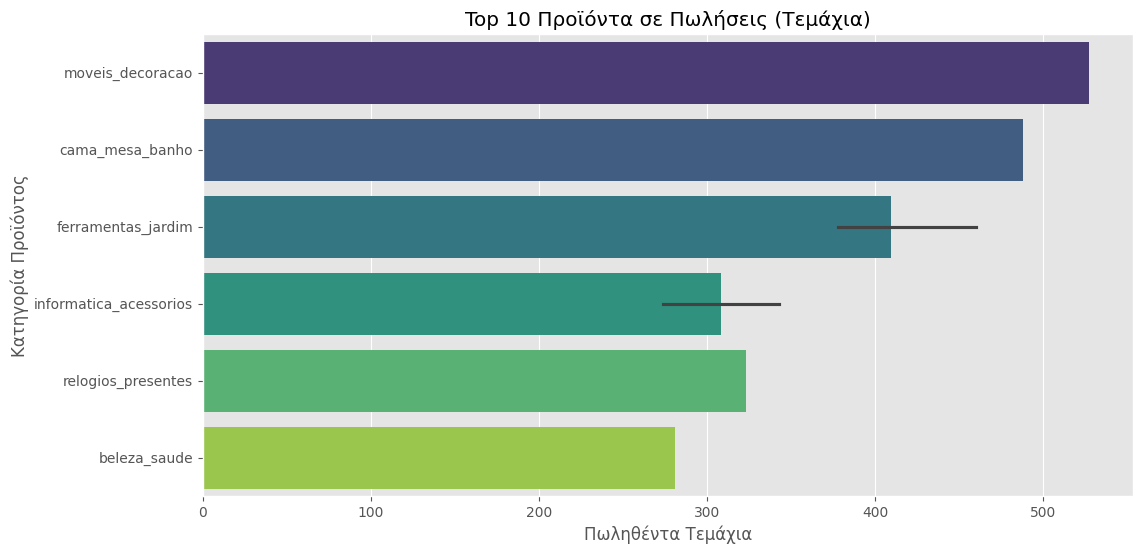

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_selling,
    x='units_sold',
    y='product_category_name',
    palette='viridis'
)
plt.title('Top 10 Προϊόντα σε Πωλήσεις (Τεμάχια)')
plt.xlabel('Πωληθέντα Τεμάχια')
plt.ylabel('Κατηγορία Προϊόντος')
plt.show()

<ipython-input-16-0a99edd24f68>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


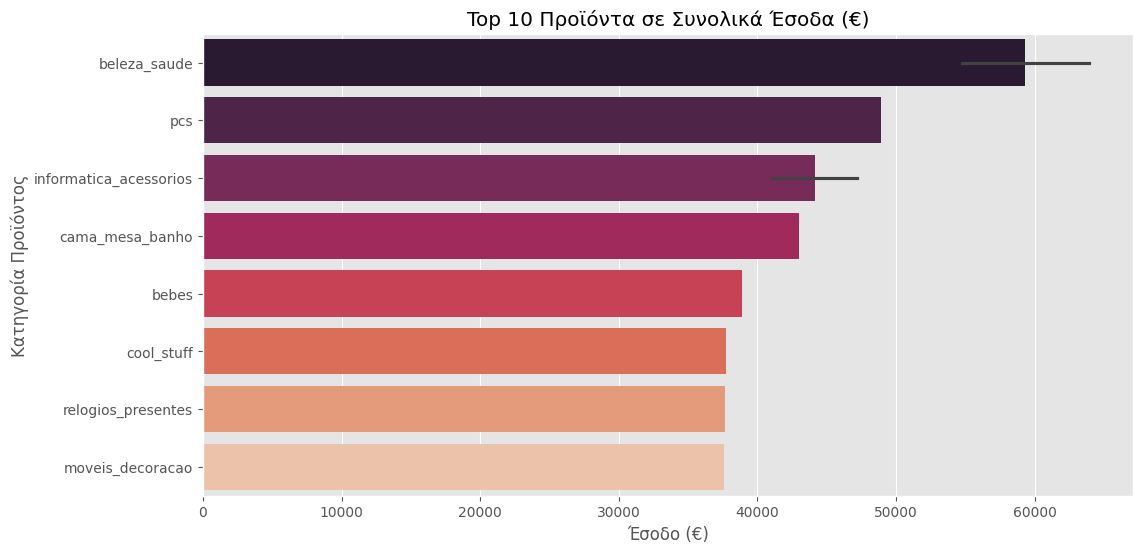

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_revenue,
    x='total_revenue',
    y='product_category_name',
    palette='rocket'
)
plt.title('Top 10 Προϊόντα σε Συνολικά Έσοδα (€)')
plt.xlabel('Έσοδο (€)')
plt.ylabel('Κατηγορία Προϊόντος')
plt.show()

<ipython-input-17-7419ae9f17fe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


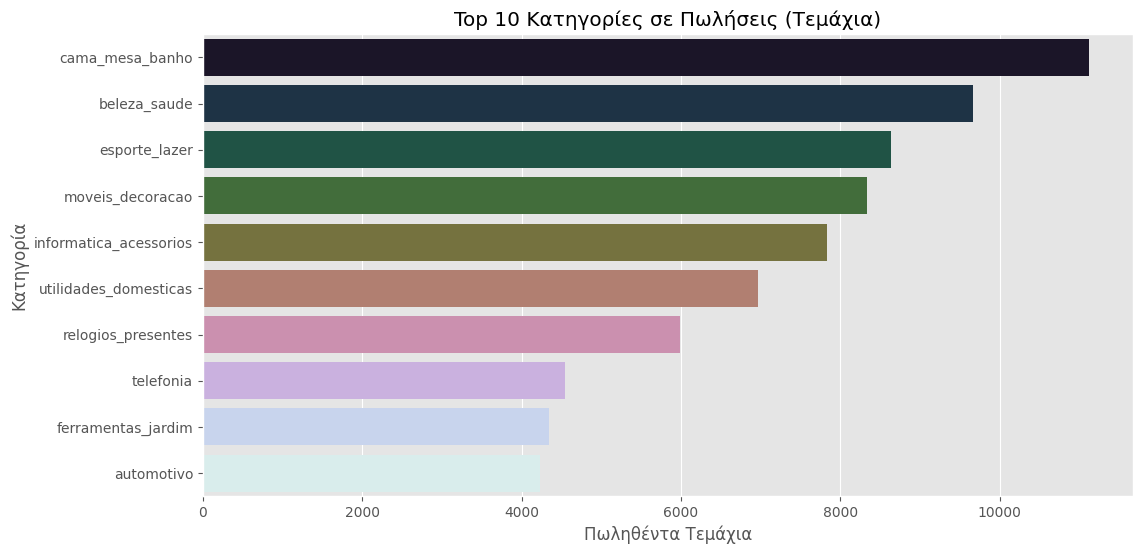

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=category_metrics.head(10),
    x='units_sold',
    y='product_category_name',
    palette='cubehelix'
)
plt.title('Top 10 Κατηγορίες σε Πωλήσεις (Τεμάχια)')
plt.xlabel('Πωληθέντα Τεμάχια')
plt.ylabel('Κατηγορία')
plt.show()

In [ ]:
category_metrics.sort_values('total_revenue', ascending=False).head(10)

,product_category_name,units_sold,total_revenue,total_freight
1,beleza_saude,9670,1258681.34,182566.73
6,relogios_presentes,5991,1205005.68,100535.93
0,cama_mesa_banho,11115,1036988.68,204693.04
2,esporte_lazer,8641,988048.97,168607.51
4,informatica_acessorios,7827,911954.32,147318.08
3,moveis_decoracao,8334,729762.49,172749.30
11,cool_stuff,3796,635290.85,84039.10
5,utilidades_domesticas,6964,632248.66,146149.11
9,automotivo,4235,592720.11,92664.21
8,ferramentas_jardim,4347,485256.46,98962.75


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv


In [ ]:
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv", parse_dates=[
    'review_creation_date', 'review_answer_timestamp'
])

In [ ]:
order_reviews.head()
order_reviews['review_score'].value_counts().sort_index()

,count
review_score,
1,11424
2,3151
3,8179
4,19142
5,57328


## 8. Sentiment Analysis & Word Clouds

In [ ]:
reviews_merged = order_reviews.merge(orders[['order_id', 'order_status', 'order_delivered_customer_date', 'order_purchase_timestamp']], on='order_id', how='left')

In [ ]:
reviews_merged['delivery_days'] = (reviews_merged['order_delivered_customer_date'] - reviews_merged['order_purchase_timestamp']).dt.days

In [ ]:
delivery_days.describe()

NameError: name 'delivery_days' is not defined

In [ ]:
reviews_merged.groupby('review_score')['delivery_days'].describe()

,count,mean,std,min,25%,50%,75%,max
review_score,,,,,,,,
1,9409.0,20.849825,16.059046,0.0,9.0,16.0,30.0,195.0
2,2941.0,16.194832,12.486474,1.0,8.0,13.0,22.0,208.0
3,7962.0,13.795278,9.943568,0.0,7.0,12.0,18.0,188.0
4,18987.0,11.848054,8.291362,0.0,7.0,10.0,15.0,194.0
5,57060.0,10.224097,6.824501,0.0,6.0,9.0,13.0,187.0


<ipython-input-27-20e830a3a17a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_delivery_by_score, x='review_score', y='delivery_days', palette='coolwarm')


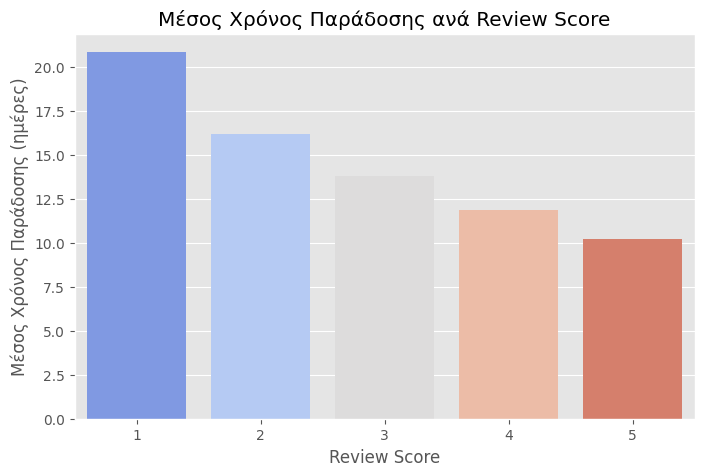

In [ ]:
avg_delivery_by_score = reviews_merged.groupby('review_score')['delivery_days'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=avg_delivery_by_score, x='review_score', y='delivery_days', palette='coolwarm')
plt.title('Μέσος Χρόνος Παράδοσης ανά Review Score')
plt.xlabel('Review Score')
plt.ylabel('Μέσος Χρόνος Παράδοσης (ημέρες)')
plt.show()

In [ ]:
reviews_merged['has_comment'] = reviews_merged['review_comment_message'].notnull()
reviews_merged['has_comment'].value_counts()

,count
has_comment,
False,58247
True,40977


In [ ]:
reviews_merged['comment_length'] = reviews_merged['review_comment_message'].astype(str).apply(len)
reviews_merged.groupby('review_score')['comment_length'].mean()

,comment_length
review_score,
1,77.208421
2,66.884164
3,37.935811
4,21.336224
5,20.510588


In [ ]:
reviews_merged.groupby('review_score')['has_comment'].mean().round(2)

,has_comment
review_score,
1,0.77
2,0.68
3,0.43
4,0.31
5,0.36


In [ ]:
!pip install wordcloud
!pip install textblob

In [ ]:
from wordcloud import WordCloud
from textblob import TextBlob

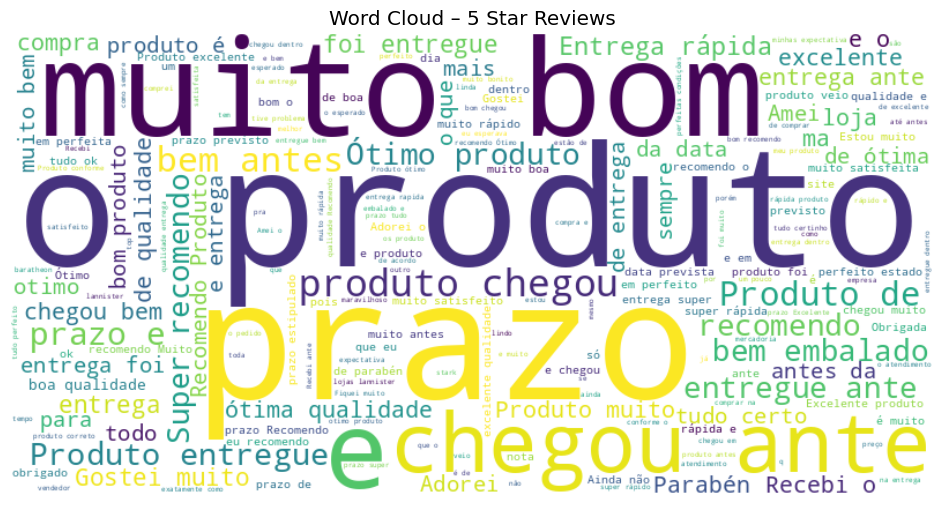

In [ ]:
text_5star = ' '.join(reviews_merged[reviews_merged['review_score'] == 5]['review_comment_message'].dropna())

wordcloud_5 = WordCloud(width=800, height=400, background_color='white').generate(text_5star)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_5, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud – 5 Star Reviews')
plt.show()

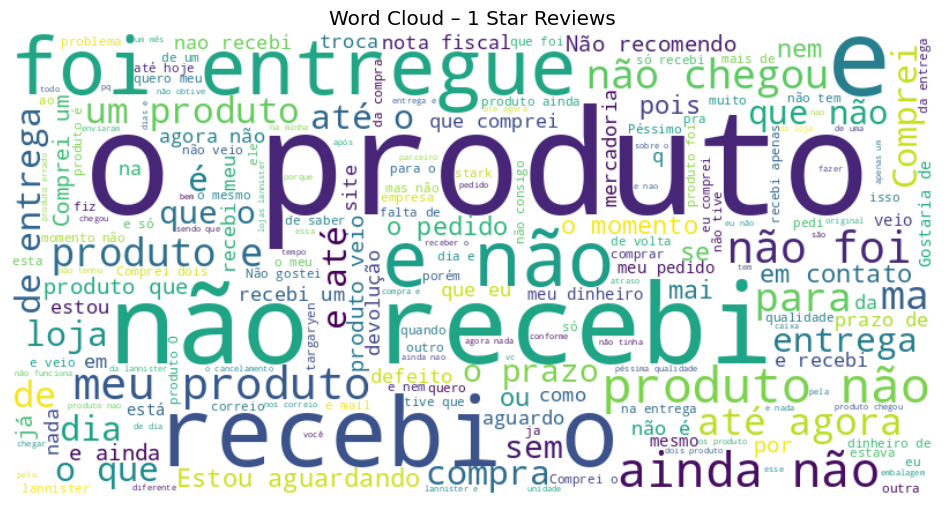

In [ ]:
text_1star = ' '.join(reviews_merged[reviews_merged['review_score'] == 1]['review_comment_message'].dropna())

wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1star)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud – 1 Star Reviews')
plt.show()

In [ ]:
def get_polarity(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

reviews_merged['polarity'] = reviews_merged['review_comment_message'].dropna().astype(str).apply(get_polarity)

In [ ]:
reviews_merged.groupby('review_score')['polarity'].mean().round(2)

,polarity
review_score,
1,0.00
2,0.01
3,0.02
4,0.03
5,0.04


In [ ]:
from collections import Counter
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 1-Star reviews keywords
text_1_clean = ' '.join(reviews_merged[reviews_merged['review_score'] == 1]['review_comment_message'].dropna().apply(clean_text))
words_1 = text_1_clean.split()
counter_1 = Counter(words_1).most_common(20)

# 5-Star reviews keywords
text_5_clean = ' '.join(reviews_merged[reviews_merged['review_score'] == 5]['review_comment_message'].dropna().apply(clean_text))
words_5 = text_5_clean.split()
counter_5 = Counter(words_5).most_common(20)

In [ ]:
print("🔴 Top 20 Keywords – 1 Star Reviews:")
print(counter_1)

print("\n🟢 Top 20 Keywords – 5 Star Reviews:")
print(counter_5)

🔴 Top 20 Keywords – 1 Star Reviews:
[('o', 7020), ('não', 6204), ('e', 5336), ('produto', 5030), ('de', 4036), ('a', 3937), ('que', 3194), ('recebi', 2766), ('do', 1935), ('um', 1902), ('com', 1820), ('foi', 1602), ('comprei', 1542), ('no', 1389), ('para', 1298), ('uma', 1245), ('da', 1212), ('ainda', 1166), ('meu', 1158), ('é', 1117)]

🟢 Top 20 Keywords – 5 Star Reviews:
[('produto', 7963), ('e', 6203), ('do', 6065), ('prazo', 5546), ('muito', 5336), ('o', 5313), ('antes', 4513), ('a', 3840), ('de', 3754), ('entrega', 3618), ('recomendo', 3191), ('chegou', 3161), ('bom', 2896), ('bem', 2179), ('que', 1959), ('com', 1956), ('no', 1906), ('qualidade', 1713), ('entregue', 1666), ('tudo', 1623)]


## 9. Final Summary

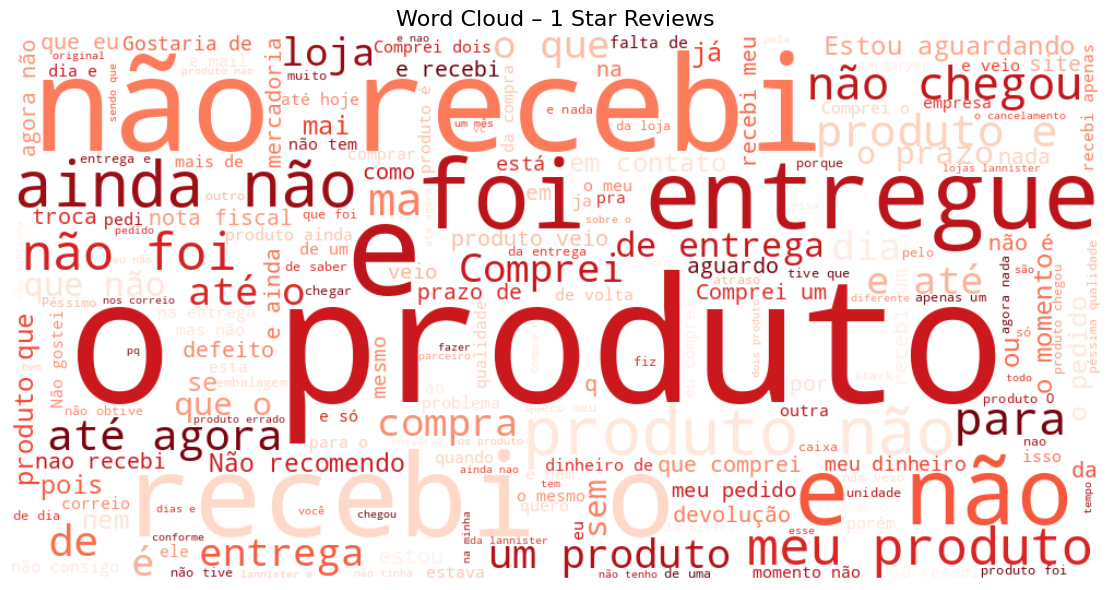

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Clean 1-star comments
text_1star = ' '.join(reviews_merged[reviews_merged['review_score'] == 1]['review_comment_message'].dropna().astype(str))

wordcloud_1 = WordCloud(width=1000, height=500, background_color='white', colormap='Reds').generate(text_1star)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud – 1 Star Reviews', fontsize=16)
plt.tight_layout()

# Save
plt.savefig('wordcloud_1star.png', dpi=300)
plt.show()

In [ ]:
order_payments['payment_type'].value_counts()

,count
payment_type,
credit_card,76795
boleto,19784
voucher,5775
debit_card,1529
not_defined,3
